# Sentinel-2 DataCube supporting functions and execution examples

The primary focus of our work to date has been to demonstrate the capability to configure and analyse data other than Landsat (out primary dataset for code testing and development). The examples presented below are demonstrations only and some additional refinement of the content presented within them and the configuration they reference is anticipated.

- step 1: prepare your datasets for ingest
- step 2: prepare system for ingest 
- step 3: index prepared datasets (datasets are now accessible to DataCube)
    - L1C local file system OK - example included
- step 4: ingest indexed datasets (datasets are now DataCube datasets)
    - L1C local file system OK
- step 5: load dataset spatiotemporal subset to analysis array
    - L1C local
- step 6: plotting and export examples
- step 7: AWS and Sen2Cor index and load examples
    - Very early examples...#TODO

## STEP 1: Prepare S2 L1C data for indexing and ingesting (writes the yaml ingest configuration)

### S2A L1C local filesystem SAFE

In [6]:
s2granule_prepare='/home/simonaoliver/code/agdc-v2/utils/s2prepare.py'
s2_l1c_safe='/home/simonaoliver/data/S2A_OPER_PRD_MSIL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.SAFE'
# creation of the valid data bounds geometry is what consumes much of the execution time - can be commented out in preparation code
!python $s2granule_prepare  $s2_l1c_safe
s2_l1c_safeyaml_path='/home/simonaoliver/data/S2A_OPER_PRD_MSIL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.SAFE/agdc-metadata.yaml'

2016-11-28 22:51:35,290 INFO Processing /home/simonaoliver/data/S2A_OPER_PRD_MSIL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.SAFE/S2A_OPER_MTD_SAFL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.xml
2016-11-28 22:52:53,479 INFO Writing 4 dataset(s) into /home/simonaoliver/data/S2A_OPER_PRD_MSIL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.SAFE/agdc-metadata.yaml


### S2A on AWS S3

##### Use the S3 metadata retrieval code to find available data for a spatiotemporal range

http://sentinel-pds.s3-website.eu-central-1.amazonaws.com/

tiles/[UTM code]/latitude band/square/[year]/[month]/[day]/[sequence]/DATA

For example, the files for individual scene are available in the following location: http://sentinel-s2-l1c.s3-website.eu-central-1.amazonaws.com/#tiles/10/S/DG/2015/12/7/0/

Where:

    [UTM code] = e.g. 10 - grid zone designator.

    latitude band = e.g. S - latitude band are lettered C- X (omitting the letters "I" and "O").

    square = e.g DG - pair of letters designating one of the 100,000-meter side grid squares inside the grid zone.

    [year] = e.g. 2015 - is the year the data was collected.

    [month] = e.g. 12 - is the month of the year the data was collected (without leading zeros).

    [day] = e.g. 7 - is the day of the month the data was collected (without leading zeros).

    [sequence] = e.g. 0 - in most cases there will be only one image per day. In case there are more (in northern latitudes), the following images will be 1,2,…\.


### Identify the MGRS cell reference using this web map service

https://mappingsupport.com/p/coordinates-mgrs-google-maps.html

### update the zone, latitude_band and square identified above

In [39]:
import urllib3
def check_url(url):
    http = urllib3.PoolManager()
    r = http.request('GET', url)
    if r.status!=200:
        #print('url not found')
        return False
    else:
        #print(r.status)
        return True
urls = {}

# set the utm zone (assume south for this exercise ie. EPSG:327 vs EPSG:326[zone])
zone = 55
latitude_band = 'H'
square = 'FA'
# prepare configurations for all of the available data for a tile
# alter the temporal ranges below to optimise testing

import time
print('working',end="")
end_year = int(time.strftime("%Y"))
for year in range(2016,end_year+1):
        for month in range(11,12):
            for day in range(1,31):
                url = 'http://sentinel-s2-l1c.s3.amazonaws.com/tiles/'+str(zone)+'/'+latitude_band+'/'+square+'/'+str(year)+'/'+str(month)+'/'+str(day)+'/0/tileInfo.json'
                sceneid=((url.split('tiles/')[1]).replace('/','.')).replace('.tileInfo.json','')
                print('.',end="")
                if check_url(url):
                    urls[sceneid] = url             


working..............................

### print the dictionary of urls for the target MGRS tile

In [40]:
urls

{'55.H.FA.2016.11.16.0': 'http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/16/0/tileInfo.json',
 '55.H.FA.2016.11.19.0': 'http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/19/0/tileInfo.json',
 '55.H.FA.2016.11.26.0': 'http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/26/0/tileInfo.json',
 '55.H.FA.2016.11.6.0': 'http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/6/0/tileInfo.json',
 '55.H.FA.2016.11.9.0': 'http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/9/0/tileInfo.json'}

In [41]:
s2granule_AWS_prepare='/home/simonaoliver/code/agdc-v2/utils/s2awsprepare.py'

### take a look at the data using rasterio library - AGDCv2 uses this under the hood

In [78]:
import rasterio
rasterio_s2open_test = rasterio.open('http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/6/0/B01.jp2')

In [81]:
rasterio_s2open_test_b1 = rasterio_s2open_test.read(1)

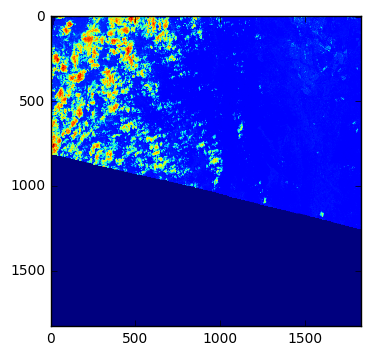

In [82]:
plt.imshow(rasterio_s2open_test_b1)

### loop through the url dict
### prepare each of the target tiles for ingest
### write the yaml configuration locally with an explicit path to help DataCube decode the target file

In [42]:
for key in urls.keys():
    print(urls[key])
    output_yaml = key+'.yaml'
    tileinfo = urls[key]
    !python $s2granule_AWS_prepare $tileinfo --output $output_yaml


http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/16/0/tileInfo.json
http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/19/0/tileInfo.json
http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/9/0/tileInfo.json
http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/6/0/tileInfo.json
http://sentinel-s2-l1c.s3.amazonaws.com/tiles/55/H/FA/2016/11/26/0/tileInfo.json


## Sen2Cor output Surface Reflectance (SR) and Scene Classification (SC)

### prepare an example Sen2Cor dataset. 
### note the performance issues related to format and drivers: http://www.gdal.org/frmt_sentinel2.html

In [60]:
s2granule_sen2cor_prepare='/home/simonaoliver/code/agdc-v2/utils/sen2cor_prepare.py'
sen2cor_safe = '/media/simonaoliver/datacube/input/S2_NBAR/S2A_USER_PRD_MSIL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.SAFE'
sen2cor_safe_yaml = '/media/simonaoliver/datacube/input/S2_NBAR/S2A_USER_PRD_MSIL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.SAFE/agdc-metadata.yaml'

!python $s2granule_sen2cor_prepare $sen2cor_safe --output $sen2cor_safe_yaml

2016-11-29 07:32:07,483 INFO Processing /media/simonaoliver/datacube/input/S2_NBAR/S2A_USER_PRD_MSIL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.SAFE/S2A_USER_MTD_SAFL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.xml
2016-11-29 07:32:10,629 INFO Writing 13 dataset(s) into /media/simonaoliver/datacube/input/S2_NBAR/S2A_USER_PRD_MSIL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.SAFE/agdc-metadata.yaml


### define the dataset type (product definition - includes S2 L1C and Sen2Cor index support)

In [3]:
s2granule_dataset_type='/home/simonaoliver/code/agdc-v2/docs/config_samples/dataset_types/s2_granules.yaml'
sen2corgranule_dataset_type='/home/simonaoliver/code/agdc-v2_20161031/docs/config_samples/dataset_types/s2_granules_SCL_only.yaml'

# STEP 2: Prepare System for ingest
## Add the S2 products to the AGDC database

In [4]:
# Remove old datacube db instances if they exist and create a new
!dropdb datacube
!createdb datacube
# initialise the database to prepare to product addition
!datacube system init
# add the product configurations to enable indexing of prepared data
!datacube -v product add $s2granule_dataset_type
!datacube system check

Initialising database...
Created.
Checking indexes/views.
Done.
2016-11-28 22:49:48,036 datacube INFO Running datacube command: /home/simonaoliver/venvs/py35/bin/datacube -v product add /home/simonaoliver/code/agdc-v2/docs/config_samples/dataset_types/s2_granules.yaml
2016-11-28 22:49:51,252 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_granule_lat_lon_time
2016-11-28 22:49:51,323 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_granule_time_lat_lon
2016-11-28 22:49:51,415 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_granule_sat_path_sat_row_time
2016-11-28 22:49:51,569 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_granule_orbit
Added "s2a_level1c_granule"
2016-11-28 22:49:56,319 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_sen2cor_granule_lat_lon_time
2016-11-28 22:49:56,390 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_sen2cor_granule_time_lat_lon
2016-11-28 

# STEP 3: Index the prepared datasets
## S2 datasets to the AGDC database - this supports on-the-fly datacube creation - datacube can decode the underlying dataset

### Index the local L1C datasets

In [7]:
!datacube -v dataset add $s2_l1c_safeyaml_path --auto-match

2016-11-28 22:53:02,992 datacube INFO Running datacube command: /home/simonaoliver/venvs/py35/bin/datacube -v dataset add /home/simonaoliver/data/S2A_OPER_PRD_MSIL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.SAFE/agdc-metadata.yaml --auto-match
2016-11-28 22:53:03,426 datacube-dataset INFO Matched Dataset <id=0df6b9f1-ae18-4b8f-a65f-fb11345e47fc type=s2a_level1c_granule location=/home/simonaoliver/data/S2A_OPER_PRD_MSIL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.SAFE/agdc-metadata.yaml>
2016-11-28 22:53:03,431 datacube.index._datasets INFO Indexing 0df6b9f1-ae18-4b8f-a65f-fb11345e47fc
2016-11-28 22:53:03,834 datacube-dataset INFO Matched Dataset <id=ed0063ef-2a31-4c3f-885c-45e7e263ad5d type=s2a_level1c_granule location=/home/simonaoliver/data/S2A_OPER_PRD_MSIL1C_PDMC_20151205T075851_R073_V20151205T001643_20151205T001643.SAFE/agdc-metadata.yaml>
2016-11-28 22:53:03,836 datacube.index._datasets INFO Indexing ed0063ef-2a31-4c3f-885c-45e7e263ad5d
2016-11-

# STEP 4: Ingest the indexed datasets
## The above indexes the source input dataset - now we can ingest to a DataCube dataset NetCDF4.CF1.6 as described by the ingester configuration file

#### change the destination 'location' in s2aingester10 below

In [8]:
s2aingester10 = '/home/simonaoliver/code/agdc-v2/docs/config_samples/ingester/s2amsil1c_albers_10.yaml'
!datacube -v ingest --config-file $s2aingester10

2016-11-28 22:53:16,303 datacube INFO Running datacube command: /home/simonaoliver/venvs/py35/bin/datacube -v ingest --config-file /home/simonaoliver/code/agdc-v2/docs/config_samples/ingester/s2amsil1c_albers_10.yaml
2016-11-28 22:53:16,710 agdc-ingest INFO Created DatasetType s2a_level1c_albers_10
2016-11-28 22:53:17,079 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_albers_10_lat_lon_time
2016-11-28 22:53:17,139 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_albers_10_time_lat_lon
2016-11-28 22:53:17,235 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_albers_10_sat_path_sat_row_time
2016-11-28 22:53:17,263 datacube.index.postgres._dynamic INFO Creating index: dix_s2a_level1c_albers_10_orbit
2016-11-28 22:53:17,890 agdc-ingest INFO 7 tasks discovered
2016-11-28 22:53:18,169 agdc-ingest INFO Submitting task: (14, -40, numpy.datetime64('2015-12-05T00:16:43.498000000'))
2016-11-28 22:53:18,276 agdc-ingest INFO Submitting

# STEP 5: Load a spatiotemporal subset of the ingested data

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import datacube
from datacube.model import Range
from datetime import datetime
dc = datacube.Datacube(app='dc-example')
from datacube.storage import masking
from datacube.storage.masking import mask_valid_data as mask_invalid_data
import pandas
import xarray
import numpy

In [10]:
import folium
from IPython.display import display
import geopandas
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon
import rasterio
import shapely.geometry
import shapely.ops
from functools import partial
import pyproj
from datacube.model import CRS

In [11]:
def datasets_union(dss, inputcrs):
    thing = shapely.ops.unary_union([shapely.geometry.Polygon(ds.extent.points) for ds in dss])
    return shapely.geometry.shape(rasterio.warp.transform_geom(inputcrs,'EPSG:4326',
                                        shapely.geometry.mapping(thing)))

In [13]:
import random
def plot_folium(shapes):

    mapa = folium.Map(location=[-30,150], zoom_start=4)
    colors=['#00ff00', '#ff0000', '#00ffff', '#ffffff', '#000000', '#ff00ff']
    for shape in shapes:
        style_function = lambda x: {'fillColor': '#000000' if x['type'] == 'Polygon' else '#00ff00', 
                                   'color' : random.choice(colors)}
        poly = folium.features.GeoJson(mapping(shape), style_function=style_function)
        mapa.add_children(poly)
    display(mapa)

In [14]:
def plot_rgb(image, fake_saturation):
    image = mask_invalid_data(image)
    rgb = image.to_array(dim='color')
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow

    rgb.plot.imshow(x=image.crs.dimensions[1], y=image.crs.dimensions[0],
                col='time', col_wrap=5, add_colorbar=False)

### List the indexable products

In [15]:
dc.list_products()

,name,description,platform,instrument,lat,time,format,sat_path,product_type,lon,sat_row,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
3,s2a_level1c_albers_10,"Sentinel-2A MSI L1C 10 metre, 100km tile, Aust...",SENTINEL_2A,MSI,None,None,NetCDF,None,S2MSI1C,None,None,EPSG:3577,"[-10, 10]","[100000.0, 100000.0]","(y, x)"
1,s2a_level1c_granule,Sentinel-2 Level 1 - Ortho Rectified,SENTINEL_2A,MSI,None,None,JPEG2000,None,S2MSI1C,None,None,NaN,NaN,NaN,NaN
2,s2a_sen2cor_granule,Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...,SENTINEL_2A,MSI,None,None,JPEG2000,None,S2MSI2Ap,None,None,NaN,NaN,NaN,NaN


### List the available measurements for each product

In [16]:
dc.list_measurements()

aliases   dtype  \
product               measurement                                   
s2a_level1c_albers_10 blue          [band_02, B02, Band2]   int16   
                      green         [band_03, B03, Band3]   int16   
                      red           [band_04, B04, Band4]   int16   
                      nir           [band_08, B08, Band8]   int16   
s2a_level1c_granule   01            [band_01, B01, Band1]  uint16   
                      02            [band_02, B02, Band2]  uint16   
                      03            [band_03, B03, Band3]  uint16   
                      04            [band_04, B04, Band4]  uint16   
                      05            [band_05, B05, Band5]  uint16   
                      06            [band_06, B06, Band6]  uint16   
                      07            [band_07, B07, Band7]  uint16   
                      08            [band_08, B08, Band8]  uint16   
                      8A           [band_8A, B8A, Band8A]  uint16   
                      09            [band_09, B09, Band9]  uint16   
                      10           [band_10, B10, Band10]  uint16   
                      11           [band_11, B11, Band11]  uint16   
                      12           [band_12, B12, Band12]  uint16   
s2a_sen2cor_granule   B01_60m                         NaN  uint16   
                      B02_10m                         NaN  uint16   
                      B02_20m                         NaN  uint16   
                      B02_60m                         NaN  uint16   
                      B03_10m       [band_03, B03, Band3]  uint16   
                      B03_20m                         NaN  uint16   
                      B03_60m                         NaN  uint16   
                      B04_10m                         NaN  uint16   
                      B04_20m                         NaN  uint16   
                      B04_60m                         NaN  uint16   
                      B05_20m                         NaN  uint16   
                      B05_60m                         NaN  uint16   
                      B06_20m                         NaN  uint16   
                      B06_60m                         NaN  uint16   
                      B07_20m                         NaN  uint16   
                      B07_60m                         NaN  uint16   
                      B08_10m                         NaN  uint16   
                      B8A_20m                         NaN  uint16   
                      B8A_60m                         NaN  uint16   
                      B09_60m                         NaN  uint16   
                      B11_20m                         NaN  uint16   
                      B11_60m                         NaN  uint16   
                      B12_20m                         NaN  uint16   
                      B12_60m                         NaN  uint16   
                      SCL_20m                         NaN  uint16   

                                                                    flags_definition  \
product               measurement                                                      
s2a_level1c_albers_10 blue                                                       NaN   
                      green                                                      NaN   
                      red                                                        NaN   
                      nir                                                        NaN   
s2a_level1c_granule   01                                                         NaN   
                      02                                                         NaN   
                      03                                                         NaN   
                      04                                                         NaN   
                      05                                                         NaN   
                      06                     

## Show the spatial extent of the ingested datasets

In [19]:
plot_folium([datasets_union(dc.index.datasets.search_eager(product='s2a_level1c_albers_10'),'EPSG:3577')])

In [20]:
plot_folium([datasets_union(dc.index.datasets.search_eager(product='s2a_level1c_granule'),'EPSG:32755')])

### Load spatiotemporal range of available L1C data - don't care where it is sitting (on AWS S3 or locally)

#### List the count of products per year

In [23]:
import time
years = list(range(2015,2017))
products = dc.list_products().name
start_time = time.time()
for year in years:
    for item in products:
        datasets = dc.index.datasets.count(product=item, time=Range(datetime(year, 1, 1), datetime(year+1, 1, 1)))
        print(year, item, datasets)
    print("*****************************")
print("--- %s seconds ---" % (time.time() - start_time))

2015 s2a_level1c_albers_10 7
2015 s2a_level1c_granule 4
2015 s2a_sen2cor_granule 0
*****************************
2016 s2a_level1c_albers_10 0
2016 s2a_level1c_granule 0
2016 s2a_sen2cor_granule 0
*****************************
--- 0.30237841606140137 seconds ---


In [25]:
s2a_l1c_albers_10m = dc.load(product='s2a_level1c_albers_10', x=(147.36, 147.41), y=(-35.1, -35.15), measurements=['red','green','blue'])

In [26]:
s2a_l1c_albers_10m

<xarray.Dataset>
Dimensions:  (time: 1, x: 519, y: 608)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-05T00:16:43.498000
  * y        (y) float64 -3.917e+06 -3.917e+06 -3.917e+06 -3.917e+06 ...
  * x        (x) float64 1.393e+06 1.393e+06 1.393e+06 1.393e+06 1.393e+06 ...
Data variables:
    red      (time, y, x) int16 1857 1970 2020 2155 2095 1551 1576 1558 1615 ...
    green    (time, y, x) int16 1692 1750 1759 1842 1801 1442 1444 1443 1496 ...
    blue     (time, y, x) int16 1604 1573 1636 1701 1657 1406 1391 1377 1390 ...
Attributes:
    crs: EPSG:3577

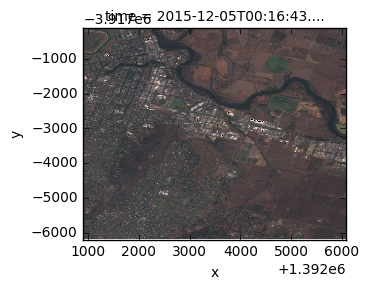

In [31]:
plot_rgb(s2a_l1c_albers_10m,5000)

## Write to example output NetCDF

In [32]:
# if the file already exists - delete it
import os
from datacube.storage.storage import write_dataset_to_netcdf
netcdf_write_example = '/home/simonaoliver/example.nc'
if os.path.isfile(netcdf_write_example):
    os.remove(netcdf_write_example)
# write the file
write_dataset_to_netcdf(s2a_l1c_albers_10m, netcdf_write_example)

## Read back as xarray

In [33]:
import xarray
example = xarray.open_dataset('/home/simonaoliver/example.nc')

In [36]:
example

<xarray.Dataset>
Dimensions:  (time: 1, x: 519, y: 608)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-05T00:16:43
  * y        (y) float64 -3.917e+06 -3.917e+06 -3.917e+06 -3.917e+06 ...
  * x        (x) float64 1.393e+06 1.393e+06 1.393e+06 1.393e+06 1.393e+06 ...
Data variables:
    crs      int32 -2147483647
    red      (time, y, x) float64 1.857e+03 1.97e+03 2.02e+03 2.155e+03 ...
    green    (time, y, x) float64 1.692e+03 1.75e+03 1.759e+03 1.842e+03 ...
    blue     (time, y, x) float64 1.604e+03 1.573e+03 1.636e+03 1.701e+03 ...
Attributes:
    date_created: 2016-11-29T06:26:29.248444
    Conventions: CF-1.6, ACDD-1.3
    history: NetCDF-CF file created by datacube version '1.1.13+54.gd4580e9' at 20161128.
    geospatial_bounds: POLYGON((147.35264936250474 -35.10064713930384, 147.3606680606264 -35.15492100547392, 147.41734946091296 -35.14931304041414, 147.40930174877633 -35.09504284276099, 147.35264936250474 -35.10064713930384))
    geospatial_bounds_crs: EPSG:4326
 

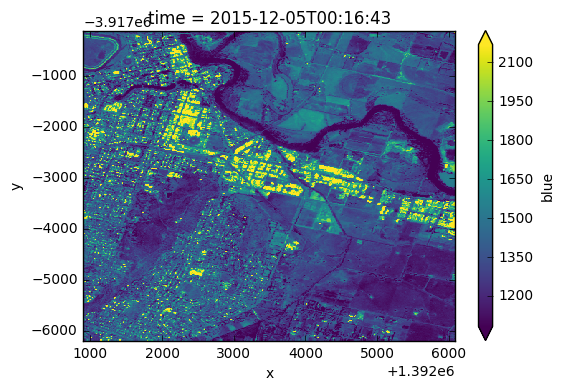

In [37]:
example['blue'].plot(robust = True)

In [ ]:
s2a_sen2cor_60m = dc.load(product='s2a_sen2cor_granule_scl',x=(147.36, 147.41), y=(-37.1, -37.15), measurements=['SCL_20m'], output_crs='EPSG:4326', resolution=(-0.0060, 0.0060))

# STEP 7 AWS and Sen2Cor index and load examples 

### Index the AWS datasets

In [43]:
for key in urls.keys():
    output_yaml = key+'.yaml'
    !datacube -v dataset add $output_yaml --auto-match

2016-11-29 06:43:37,209 datacube INFO Running datacube command: /home/simonaoliver/venvs/py35/bin/datacube -v dataset add 55.H.FA.2016.11.16.0.yaml --auto-match
2016-11-29 06:43:37,532 datacube-dataset INFO Matched Dataset <id=da542cb3-1a00-57b2-911d-f773f987ce8d type=s2a_level1c_granule location=/home/simonaoliver/code/testing_notebooks/55.H.FA.2016.11.16.0.yaml>
2016-11-29 06:43:37,534 datacube.index._datasets INFO Indexing da542cb3-1a00-57b2-911d-f773f987ce8d
2016-11-29 06:43:42,945 datacube INFO Running datacube command: /home/simonaoliver/venvs/py35/bin/datacube -v dataset add 55.H.FA.2016.11.19.0.yaml --auto-match
2016-11-29 06:43:43,033 datacube-dataset INFO Matched Dataset <id=8be4c6eb-8e28-522d-a768-d4a16cb54be0 type=s2a_level1c_granule location=/home/simonaoliver/code/testing_notebooks/55.H.FA.2016.11.19.0.yaml>
2016-11-29 06:43:43,034 datacube.index._datasets INFO Indexing 8be4c6eb-8e28-522d-a768-d4a16cb54be0
2016-11-29 06:43:48,639 datacube INFO Running datacube command: /h

In [44]:
for year in years:
    for item in products:
        datasets = dc.index.datasets.count(product=item, time=Range(datetime(year, 1, 1), datetime(year+1, 1, 1)))
        print(year, item, datasets)
    print("*****************************")
print("--- %s seconds ---" % (time.time() - start_time))

2015 s2a_level1c_albers_10 7
2015 s2a_level1c_granule 4
2015 s2a_sen2cor_granule 0
*****************************
2016 s2a_level1c_albers_10 0
2016 s2a_level1c_granule 5
2016 s2a_sen2cor_granule 0
*****************************
--- 1464.5929667949677 seconds ---


In [51]:
plot_folium([datasets_union(dc.index.datasets.search_eager(product='s2a_level1c_granule'\
            ,time=Range(datetime(2016,11, 24), datetime(2017, 1, 1))),'EPSG:32755')])

In [83]:
#TODO s2a_l1c_granule = dc.load(product='s2a_level1c_granule', x=(148.76, 148.77), y=(-35.32, -35.33), output_crs='EPSG:4326', resolution=(-0.0006,0.00060))

In [ ]:
# TODO s2a_l1c_granule

In [93]:
s2a_l1c_granule = dc.load(product='s2a_level1c_granule', measurements=['01'], time=('2016-11-24','2016-11-30'), output_crs='EPSG:32755', resolution=(-60,60))

In [94]:
s2a_l1c_granule

<xarray.Dataset>
Dimensions:  (time: 1, x: 1830, y: 599)
Coordinates:
  * time     (time) datetime64[ns] 2016-11-26T00:02:16.461000
  * y        (y) float64 6.1e+06 6.1e+06 6.1e+06 6.1e+06 6.1e+06 6.1e+06 ...
  * x        (x) float64 6e+05 6.001e+05 6.002e+05 6.002e+05 6.003e+05 ...
Data variables:
    01       (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs: EPSG:32755

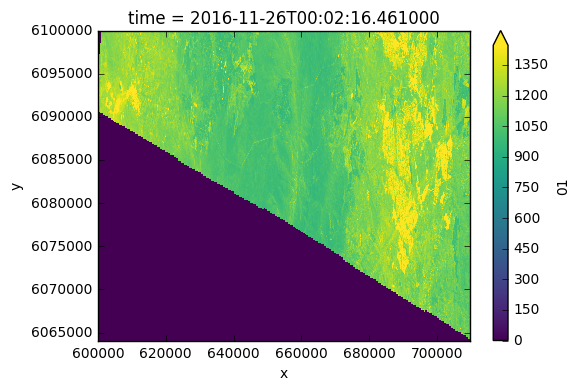

In [69]:
s2a_l1c_granule['01'].plot(robust=True)

### Index the sen2cor datasets

In [63]:
!datacube -v dataset add $sen2cor_safe_yaml --auto-match

2016-11-29 07:34:14,883 datacube INFO Running datacube command: /home/simonaoliver/venvs/py35/bin/datacube -v dataset add /media/simonaoliver/datacube/input/S2_NBAR/S2A_USER_PRD_MSIL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.SAFE/agdc-metadata.yaml --auto-match
2016-11-29 07:34:15,119 datacube-dataset INFO Matched Dataset <id=edf95a4c-da99-4bdc-8823-280b3aa8b84f type=s2a_sen2cor_granule location=/media/simonaoliver/datacube/input/S2_NBAR/S2A_USER_PRD_MSIL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.SAFE/agdc-metadata.yaml>
2016-11-29 07:34:15,123 datacube.index._datasets INFO Indexing edf95a4c-da99-4bdc-8823-280b3aa8b84f
2016-11-29 07:34:15,298 datacube-dataset INFO Matched Dataset <id=56e5d115-2f74-40ba-8d3d-293c7f3e424d type=s2a_sen2cor_granule location=/media/simonaoliver/datacube/input/S2_NBAR/S2A_USER_PRD_MSIL2A_PDMC_20160314T110945_R073_V20160314T001209_20160314T001209.SAFE/agdc-metadata.yaml>
2016-11-29 07:34:15,298 datacube.index._datasets IN

In [89]:
plot_folium([datasets_union(dc.index.datasets.search_eager(product='s2a_sen2cor_granule'),'EPSG:32755')])

In [98]:
# TODO sen2corSCL = dc.load(product='s2a_sen2cor_granule', measurements=['SCL_20m'], output_crs='EPSG:4326', resolution=(-0.0025, 0.0025))

In [99]:
# TODO sen2corSCL